# Prophet 을 이용한 예측 
- 매일의 daily_sales만을 이용해서 Prophet 모델을 적용한 코드입니다. 
- 전처리
    - Qty가 0 이하인 값은 모두 0으로 바꿔줍니다. 
- 모델 학습 (Prophet)
    - 독일의 공휴일을 파라미터로 넣어줍니다. 
    - 12월 및 주말에 대한 정보를 파라미터로 넣어줍니다. 
- 후처리 
    - 값이 음수이거나 공휴일과 주말에 높은 값을 가지면 40(기존 주말 공휴일의 평균적인 Qty)으로 대체해줍니다. (기존에 주말과 공휴일에는 일반적으로 낮은 Qty를 가짐) 

In [ ]:
# 패키지를 설치합니다. 
!conda install -y gcc 
!conda install -y -c conda-forge fbprophet

In [ ]:
%matplotlib inline
# 패키지를 로드합니다. 
import pandas as pd
from fbprophet import Prophet

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
# 데이터를 불러옵니다. 
path = '/home/workspace/data/.train/.task152/train/'
train = pd.read_csv(path + '1_daily_sales.csv')

In [ ]:
# 0이하의 값은 모두 0으로 전처리를 진행합니다. 
train.loc[train['Qty'] < 0, 'Qty'] = 0

In [ ]:
# YYYYMMDD으로 Qty의 평균을 내서 계산합니다. 
import datetime 
train = train.groupby('YYYYMMDD')['Qty'].agg({'sum'}).reset_index()
train['Time'] = pd.to_datetime(train['YYYYMMDD'].astype(str).apply(lambda x: x[0:4] + '-' + x[4:6] + '-' + x[6:]))

In [ ]:
# Qty가 0인 항목들은 모두 제거해줍니다. 
train = train[train['sum'] != 0].reset_index(drop=True)

In [ ]:
# Prophet의 입력형태에 맞는 값으로 변경합니다. 
df = train[['Time', 'sum']]
df.columns = ['ds', 'y']

In [ ]:
# 2015-2019의 독일 공휴일 데이터를 생성합니다. 
neujahr = pd.DataFrame({
  'holiday': 'neujahr',
  'ds': pd.to_datetime(['2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01'])
})

karfreitag = pd.DataFrame({
  'holiday': 'karfreitag',
  'ds': pd.to_datetime(['2015-04-03', '2015-04-06', '2016-03-25', '2016-03-28', '2017-04-14', '2017-04-17', 
                       '2018-03-30', '2018-04-02', '2019-04-19', '2019-04-22'])
})

tagderarbeit = pd.DataFrame({
  'holiday': 'tagderarbeit',
  'ds': pd.to_datetime(['2015-05-01', '2016-05-01', '2017-05-01', '2018-05-01', '2019-05-01'])
})

ChristiHimmelfahrt = pd.DataFrame({
  'holiday': 'ChristiHimmelfahrt',
  'ds': pd.to_datetime(['2015-05-14', '2016-05-05', '2017-05-25', '2018-05-10', '2019-05-30'])
})

pfingetmontag = pd.DataFrame({
  'holiday': 'pfingetmontag',
  'ds': pd.to_datetime(['2015-05-25', '2016-05-16', '2017-06-05', '2018-05-21', '2019-06-10'])
})

tagderdeuscheneinheit = pd.DataFrame({
  'holiday': 'tagderdeuscheneinheit',
  'ds': pd.to_datetime(['2015-10-03', '2016-10-03', '2017-10-03', '2018-10-03', '2019-10-03'])
})

chrismas = pd.DataFrame({
  'holiday': 'chrismas',
  'ds': pd.to_datetime(['2015-12-25', '2016-12-25', '2017-12-25', '2018-12-25', '2019-12-25', 
                       '2015-12-26', '2016-12-26', '2017-12-26', '2018-12-26', '2019-12-26'])
})

holidays = pd.concat([neujahr, karfreitag, tagderarbeit, ChristiHimmelfahrt, pfingetmontag, 
                      tagderdeuscheneinheit, chrismas
                     ], axis=0)

In [ ]:
# prophet 모델을 만들어줍니다. 
my_model = Prophet(interval_width=0.99, 
                yearly_seasonality=True, 
                seasonality_mode='additive', # multiplicative
                #changepoint_prior_scale = 0.001, 
                #seasonality_prior_scale = 0.001,
                holidays = holidays, 
                holidays_prior_scale = 0.01
)

In [ ]:
# 주말여부 및 12월 여부에 대한 변수를 만듭니다. 
df['on_weekend'] = pd.to_datetime(df['ds']).dt.weekday >= 5
df['off_weekend'] = ~(pd.to_datetime(df['ds']).dt.weekday >= 5)

df['on_12month'] = pd.to_datetime(df['ds']).dt.month == 12
df['off_12month'] = pd.to_datetime(df['ds']).dt.month != 12

In [ ]:
# 해당 정보에 대해서 모델에 추가해줍니다. 
my_model.add_seasonality(name='on_weekend', period=7, fourier_order=3, condition_name='on_weekend')
my_model.add_seasonality(name='off_weekend', period=7, fourier_order=3, condition_name='off_weekend')

my_model.add_seasonality(name='on_12month', period=30, fourier_order=3, condition_name='on_12month')
my_model.add_seasonality(name='off_12month', period=30, fourier_order=3, condition_name='off_12month')

# 모델의 학습을 진행합니다. 
my_model.fit(df)

import pickle
with open("my_model", "wb") as f:
     pickle.dump(my_model, f)

In [ ]:
# 테스트 데이터를 생성합니다. 
with open("my_model", "rb") as f:
    my_model = pickle.load(f)
    
future_dates = my_model.make_future_dataframe(periods=92, freq='D')

# 테스트 데이터에도 변수를 추가해줍니다. 
future_dates['on_weekend'] = pd.to_datetime(future_dates['ds']).dt.weekday >= 5
future_dates['off_weekend'] = ~(pd.to_datetime(future_dates['ds']).dt.weekday >= 5)

future_dates['on_12month'] = pd.to_datetime(future_dates['ds']).dt.month == 12
future_dates['off_12month'] = pd.to_datetime(future_dates['ds']).dt.month != 12

In [ ]:
# 예측을 진행합니다. 
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
# 예측된 결과를 뽑습니다. 
prediction = forecast.tail(92)[['ds', 'yhat']]
prediction.tail(10)

In [ ]:
# Qty값만 가져옵니다. 
prediction['Qty'] = prediction['yhat'] 
del prediction['yhat']

In [ ]:
prediction.columns = ['YYYYMMDD', 'Qty']

In [ ]:
# 후처리를 위해 Weekend가 언제인지 값을 가져옵니다. 
import pandas as pd 
prediction.loc[prediction['Qty'] < 0, 'Qty'] = 0
prediction['Time'] = pd.to_datetime(prediction['YYYYMMDD'])
prediction['weekday'] = prediction['Time'].dt.weekday
prediction['weekend'] = prediction['weekday'].map({0:0, 1:0, 2:0, 3:0, 4:0, 5:1, 6:1})
prediction['YYYYMMDD'] = prediction['Time'].dt.year * 10000 + prediction['Time'].dt.month * 100 + prediction['Time'].dt.day * 1
prediction.head()

In [ ]:
# Qty가 0보다 작은 경우에는 0값을, 주말인 경우에는 40을 넣습니다. 
prediction.loc[prediction['Qty'] < 0, 'Qty'] = 0
prediction.loc[prediction['weekend'] == 1, 'Qty'] = 40

# 휴일 (통일 기념일)에도 마찬가지로 40의 값을 넣습니다. 
prediction.loc[prediction['YYYYMMDD'] == 20191003, 'Qty'] = 40

del prediction['Time'], prediction['weekday'], prediction['weekend']

In [ ]:
# sub에 없으면 날짜는 제거해줍니다. 
prediction_path = '/home/workspace/data/baseline/task152/prediction/prediction.csv'

# 최종 제출 형식에 맞게 파일을 설정합니다. 
a = pd.read_csv(prediction_path)
sub = pd.merge(a, prediction, how='left', on='YYYYMMDD')
sub = sub[['YYYYMMDD', 'Qty_y']].rename(columns={'Qty_y':'Qty'})

In [ ]:
# 모델이 얼마나 잘 에측했는 지 확인합니다. 
from plotnine import * 
path = '/home/workspace/data/.train/.task152/train/'

train = pd.read_csv(path + '1_daily_sales.csv')
agg = train.groupby('YYYYMMDD')['Qty'].agg({'sum'}).reset_index().rename(columns={'sum':'Qty'})
agg['Type'] = 'Train'

sub_sample = sub.copy()
sub_sample['Type'] = 'Test'

agg = pd.concat([agg, sub_sample], axis=0)
agg['Time'] = pd.to_datetime(agg['YYYYMMDD'].astype(str).apply(lambda x: x[0:4] + '-' + x[4:6] + '-' + x[6:]))

(ggplot(data = agg) + 
    geom_line(aes(x='Time', y='Qty', group='Type', color='Type')))

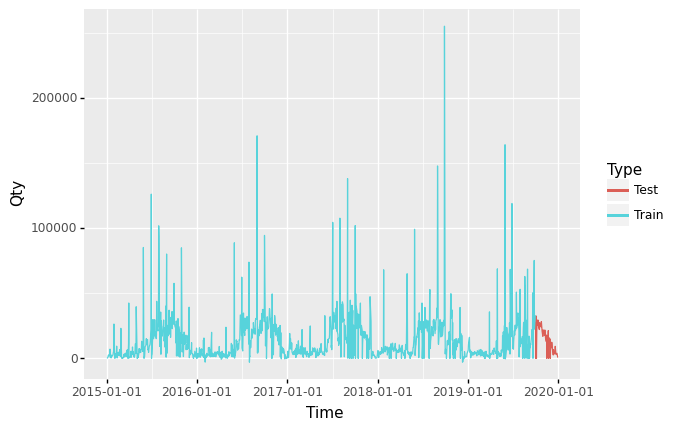

In [ ]:
# 결과를 저장합니다. 
prediction_path = "/home/workspace/user-workspace/prediction/prediction(Prophet).csv"
sub.to_csv("/home/workspace/user-workspace/prediction/prediction(Prophet).csv", index=False)

In [ ]:
import os
# prediction.to_csv("/home/workspace/user-workspace/prediction/prediction(Prophet1).csv", index=False)
from nipa.taskSubmit import nipa_submit

team_id = "1192"
task_no= "152"

# 파일 존재 여부 확인
print("is file: ", os.path.isfile(prediction_path))

# 제출 성공
nipa_submit(team_id=team_id,
    task_no=task_no,
    result=prediction_path, 
    model=model_path     
)